In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns 
sns.set()

In [3]:
data=pd.read_csv("prod_commandes_expeditions_retours_stocks.csv" , encoding="utf-8")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42458 entries, 0 to 42457
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_commande      42458 non-null  object 
 1   date_commande    42458 non-null  object 
 2   id_produit       42458 non-null  object 
 3   quantité_x       42458 non-null  int64  
 4   entrepôt_x       42458 non-null  object 
 5   statut           42458 non-null  object 
 6   id_expedition    42458 non-null  object 
 7   quantité_y       42458 non-null  float64
 8   entrepôt_y       42458 non-null  object 
 9   date_expedition  42458 non-null  object 
 10  date_livraison   42458 non-null  object 
 11  transporteur     42458 non-null  object 
 12  coût_transport   42458 non-null  float64
 13  délai_livraison  42458 non-null  float64
 14  mois_x           42458 non-null  object 
 15  date_retour      2987 non-null   object 
 16  motif            2987 non-null   object 
 17  mois_y      

In [5]:
data.rename(columns={
    'quantité_x': 'quantité_commandée',
    'quantité_y': 'quantité_expediée',
    'entrepôt_x': 'entrepot_commande',
    'entrepôt_y': 'entrepot_expedition',
    'mois_x': 'mois_commande',
    'mois_y': 'mois_retour'
}, inplace=True)


In [6]:
data.isnull().sum()

id_commande                0
date_commande              0
id_produit                 0
quantité_commandée         0
entrepot_commande          0
statut                     0
id_expedition              0
quantité_expediée          0
entrepot_expedition        0
date_expedition            0
date_livraison             0
transporteur               0
coût_transport             0
délai_livraison            0
mois_commande              0
date_retour            39471
motif                  39471
mois_retour            39471
catégorie                  0
marque                     0
prix                       0
stock_minimum              0
niveau_stock               0
entrepot                   0
dtype: int64

In [7]:

# ✅ Objectif : traiter les colonnes liées aux retours

# 1. Créer une copie du DataFrame original
data_ml = data.copy()

# 2. Créer une colonne binaire "retour" :
#    - 1 si la commande a été retournée (date_retour non nulle)
#    - 0 sinon
data_ml['retour'] = data_ml['date_retour'].notnull().astype(int)

# 3. Remplacer les valeurs manquantes :
#    - 'motif' ➜ "Aucun"
#    - 'mois_retour' ➜ "Non retourné"
data_ml['motif'] = data_ml['motif'].fillna("Aucun")
data_ml['mois_retour'] = data_ml['mois_retour'].fillna("Non retourné")

# 4. Supprimer la colonne "date_retour" (non numérique, peu utile pour modélisation)
data_ml.drop(columns=['date_retour'], inplace=True)

# 5. Vérification du résultat sur les premières lignes
data_ml[['retour', 'motif', 'mois_retour']].head()


,retour,motif,mois_retour
0,0,Aucun,Non retourné
1,0,Aucun,Non retourné
2,0,Aucun,Non retourné
3,0,Aucun,Non retourné
4,0,Aucun,Non retourné


In [8]:
# Compter le nombre de doublons exacts avant suppression
doublons_complets_avant = data_ml.duplicated().sum()
print(f"Nombre de doublons exacts avant suppression : {doublons_complets_avant}")

Nombre de doublons exacts avant suppression : 10


In [9]:
# Suppression des doublons exacts
data_ml = data_ml.drop_duplicates()
# Vérification après suppression
doublons_complets_apres = data_ml.duplicated().sum()
print(f"Nombre de doublons exacts après suppression : {doublons_complets_apres}")

Nombre de doublons exacts après suppression : 0


In [10]:
# 2️⃣ Analyse des doublons sur "id_commande"

# Compter combien de fois chaque id_commande apparaît
id_commande_counts = data_ml['id_commande'].value_counts()
id_commande_counts


id_commande
O004604    2
O013436    2
O022538    2
O007862    2
O005752    2
          ..
O049996    1
O049997    1
O049998    1
O049999    1
O050000    1
Name: count, Length: 42404, dtype: int64

In [11]:
# Filtrer les id_commande qui apparaissent plus d'une fois
id_commande_en_double = id_commande_counts[id_commande_counts > 1]

print(f"\nNombre d'id_commande apparaissant plusieurs fois : {len(id_commande_en_double)}")


Nombre d'id_commande apparaissant plusieurs fois : 44


In [12]:
# Afficher un exemple de lignes concernées
exemples_doublons_id = data_ml[data_ml['id_commande'].isin(id_commande_en_double.index)].sort_values('id_commande')

# Afficher les premières lignes concernées
exemples_doublons_id.head(10)

,id_commande,date_commande,id_produit,quantité_commandée,entrepot_commande,statut,id_expedition,quantité_expediée,entrepot_expedition,date_expedition,...,mois_commande,motif,mois_retour,catégorie,marque,prix,stock_minimum,niveau_stock,entrepot,retour
2264,O002660,2024-09-13,P00029,5,Marseille,Livré,SHP002265,5.0,Marseille,2024-09-19,...,2024-09,Client insatisfait,2024-10,Soins capillaires,Reflet d'or,277.95,82,268,Paris,1
2265,O002660,2024-09-13,P00029,5,Marseille,Livré,SHP002265,5.0,Marseille,2024-09-19,...,2024-09,Client insatisfait,2024-09,Soins capillaires,Reflet d'or,277.95,82,268,Paris,1
3563,O004182,2024-12-07,P00921,10,Paris,Livré,SHP003562,10.0,Paris,2024-12-14,...,2024-12,Mauvaise référence,2025-01,Maquillage,Aura Cristal,47.73,10,11,Marseille,1
3564,O004182,2024-12-07,P00921,10,Paris,Livré,SHP003562,10.0,Paris,2024-12-14,...,2024-12,Livraison incomplète,2024-12,Maquillage,Aura Cristal,47.73,10,11,Marseille,1
3628,O004258,2024-03-16,P00653,2,Paris,Livré,SHP003626,2.0,Paris,2024-03-23,...,2024-03,Mauvaise référence,2024-04,Maquillage,Silhouette Paris,473.41,60,101,Paris,1
3629,O004258,2024-03-16,P00653,2,Paris,Livré,SHP003626,2.0,Paris,2024-03-23,...,2024-03,Mauvaise référence,2024-03,Maquillage,Silhouette Paris,473.41,60,101,Paris,1
3635,O004264,2024-02-05,P00986,1,Marseille,Livré,SHP003632,1.0,Marseille,2024-02-11,...,2024-02,Livraison incomplète,2024-02,Maquillage,Cosmétika,452.85,90,78,Lyon,1
3636,O004264,2024-02-05,P00986,1,Marseille,Livré,SHP003632,1.0,Marseille,2024-02-11,...,2024-02,Livraison incomplète,2024-03,Maquillage,Cosmétika,452.85,90,78,Lyon,1
3919,O004604,2024-02-23,P00831,15,Marseille,Livré,SHP003915,15.0,Marseille,2024-02-29,...,2024-02,Client insatisfait,2024-03,Soins capillaires,Maison Vitalis,116.45,66,17,Lyon,1
3920,O004604,2024-02-23,P00831,15,Marseille,Livré,SHP003915,15.0,Marseille,2024-02-29,...,2024-02,Client insatisfait,2024-02,Soins capillaires,Maison Vitalis,116.45,66,17,Lyon,1


In [13]:
# 📌 Étape : Suppression des doublons sur id_commande

# ✅ Objectif : Ne conserver qu'une seule ligne par "id_commande" pour éviter les répétitions injustifiées

# Suppression en gardant la première occurrence de chaque id_commande
data_ml = data_ml.drop_duplicates(subset=['id_commande'], keep='first')

# Vérification : il ne doit plus y avoir de doublons sur id_commande
doublons_id_commande_apres = data_ml['id_commande'].duplicated().sum()
print(f"Nombre de doublons sur id_commande après suppression : {doublons_id_commande_apres}")


Nombre de doublons sur id_commande après suppression : 0


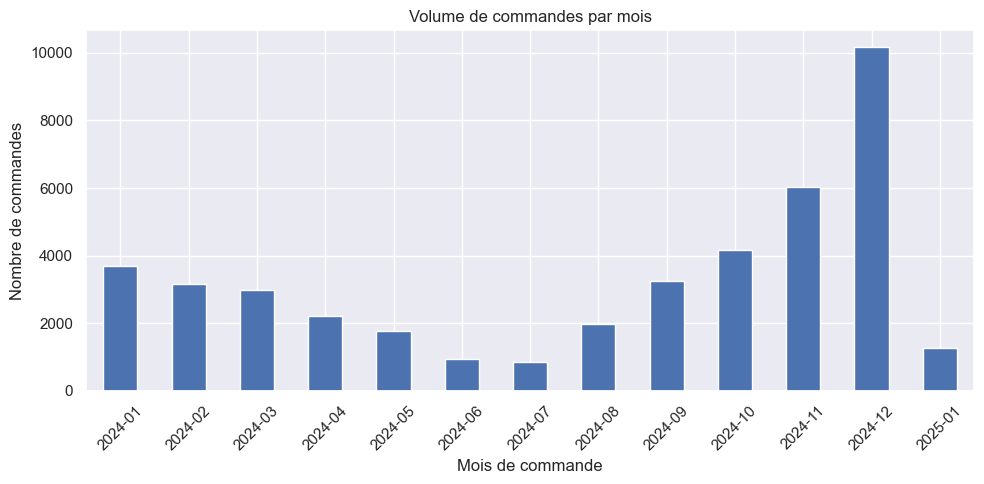

In [14]:
# 📌 Visualisation 1 : Volume de commandes par mois (Barplot)

# ✅ Objectif : Détecter la saisonnalité des commandes
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
data_ml['mois_commande'].value_counts().sort_index().plot(kind='bar')
plt.title('Volume de commandes par mois')
plt.xlabel('Mois de commande')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


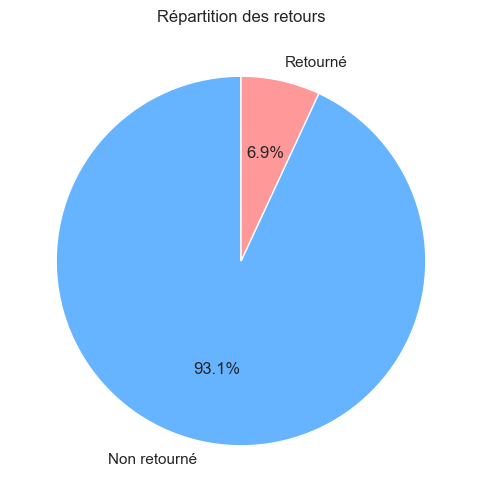

In [15]:
# 📌 Visualisation 2 : Répartition des retours vs non-retours (Pie Chart)

# ✅ Objectif : Visualiser la part des commandes retournées (satisfaction client)

retour_counts = data_ml['retour'].value_counts()
labels = ['Non retourné', 'Retourné']

plt.figure(figsize=(6,6))
plt.pie(retour_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Répartition des retours')
plt.show()


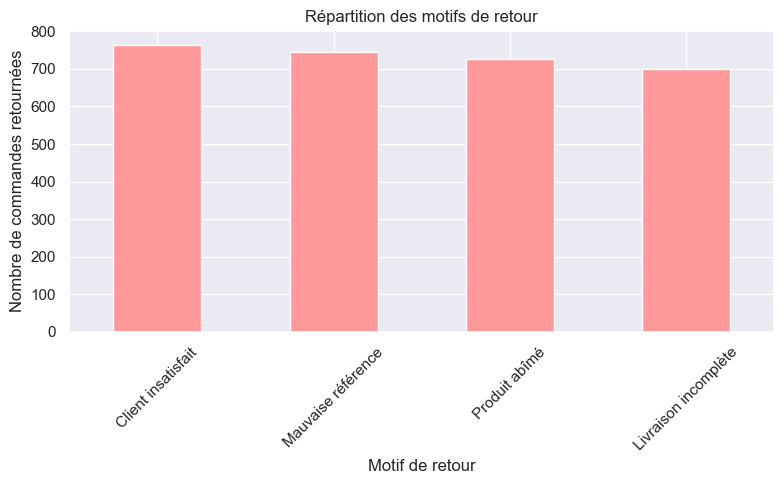

In [16]:
# 📌 Visualisation complémentaire : Répartition des motifs de retour (Barplot)

# ✅ Objectif : Comprendre pourquoi les clients retournent leurs produits

import matplotlib.pyplot as plt

# On filtre uniquement les lignes où un retour a été effectué
# Puis on compte les occurrences de chaque motif
plt.figure(figsize=(8,5))
data_ml[data_ml['retour'] == 1]['motif'].value_counts().plot(
    kind='bar',
    color='#FF9999'  # Couleur douce pour visuel agréable
)

plt.title("Répartition des motifs de retour")
plt.xlabel("Motif de retour")
plt.ylabel("Nombre de commandes retournées")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\glenn\AppData\Local\Temp\ipykernel_17748\1138752891.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


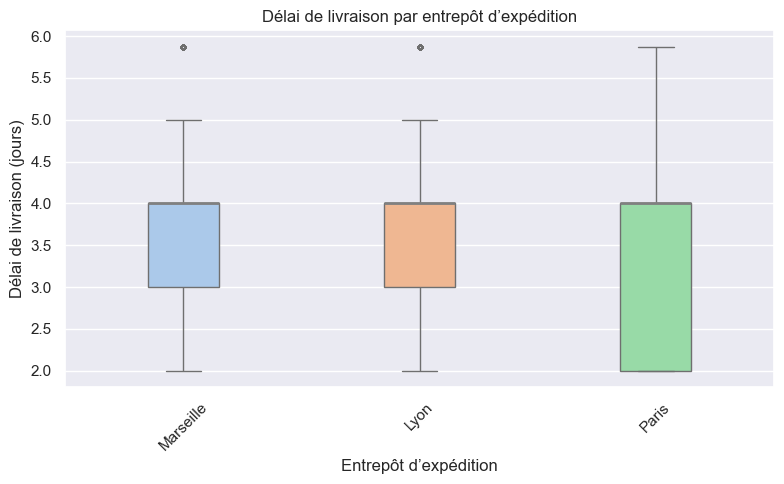

In [17]:
# 📌 Visualisation 3 : Délai de livraison par entrepôt (Boxplot)

plt.figure(figsize=(8,5))


# Utilisation de seaborn pour un boxplot propre
sns.boxplot(
    x='entrepot_expedition',
    y='délai_livraison',
    data=data_ml,
    medianprops=dict(color='grey', linewidth=2),  # Trait médiane grise
    palette='pastel',         # couleurs pastel
    width=0.3,                # largeur des boîtes
    fliersize=3               # taille des outliers (points)
)

plt.title('Délai de livraison par entrepôt d’expédition')
plt.xlabel('Entrepôt d’expédition')
plt.ylabel('Délai de livraison (jours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


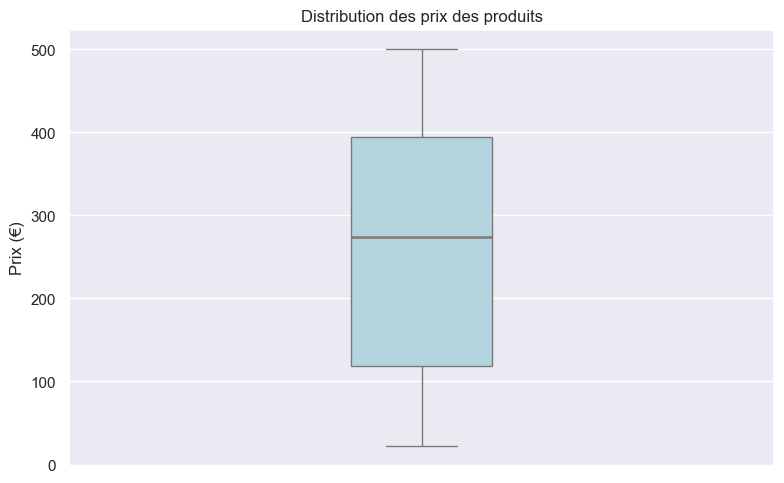

In [18]:
# 📌 Visualisation 4 : Distribution des prix des produits (Boxplot)

# ✅ Objectif : Comprendre la stratégie de prix de l'entreprise

plt.figure(figsize=(8,5))
sns.boxplot(
    y='prix',
    data=data_ml,
    color='#ADD8E6',   # Couleur de la boîte (bleu clair ici)
    width=0.2,           # largeur des boîtes
    fliersize=3 ,              # taille des outliers (points)
    medianprops=dict(color='grey', linewidth=2)  # Trait médiane grise
)
plt.title('Distribution des prix des produits')
plt.ylabel('Prix (€)')
plt.tight_layout()
plt.show()

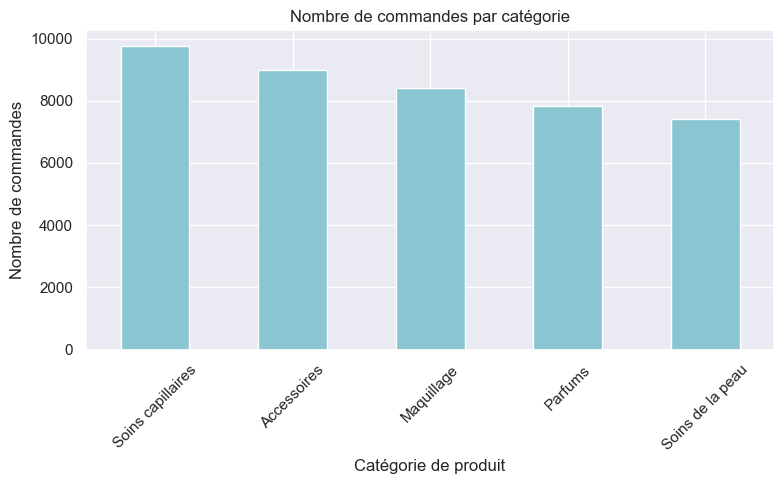

In [19]:
# 📌 Visualisation 5 : Nombre de commandes par catégorie de produit (Barplot)

# ✅ Objectif : Analyser la popularité des catégories de produits

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
data_ml['catégorie'].value_counts().plot(kind='bar', color='#8AC6D1')
plt.title('Nombre de commandes par catégorie')
plt.xlabel('Catégorie de produit')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


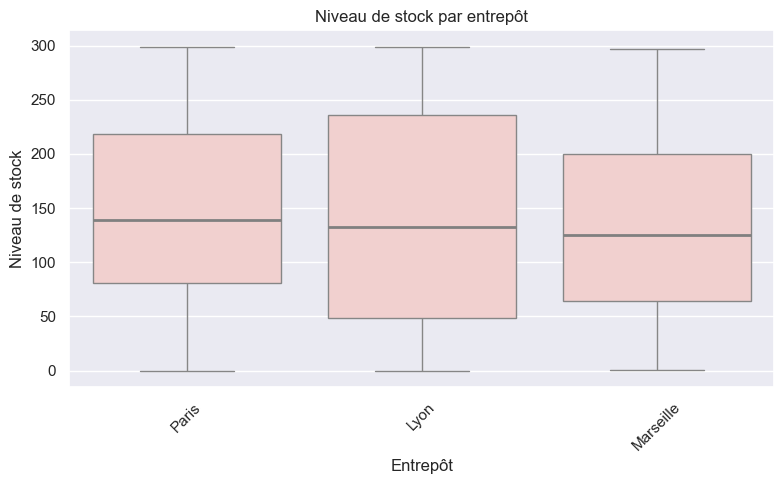

In [20]:
# 📌 Visualisation 6 : Niveau de stock par entrepôt (Boxplot)

# ✅ Objectif : Comparer la distribution du niveau de stock par entrepôt

plt.figure(figsize=(8,5))
sns.boxplot(
    x='entrepot',
    y='niveau_stock',
    data=data_ml,
    color='#F7CAC9',  # Couleur douce rose clair
    medianprops=dict(color='grey', linewidth=2)  # Trait de médiane bien visible
)

plt.title('Niveau de stock par entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Niveau de stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# 📌 Calcul des KPIs orientés client-entreprise

# 1️⃣ Taux de retour global
# Pourcentage de commandes retournées
taux_retour = data_ml['retour'].mean() * 100

# 2️⃣ Délai moyen et médian de livraison
# Permet de mesurer la performance logistique
delai_moyen = data_ml['délai_livraison'].mean()
delai_median = data_ml['délai_livraison'].median()

# 3️⃣ Nombre moyen de produits par commande
# Supposition : une ligne = un produit d'une commande
produits_par_commande = data_ml.groupby('id_commande').size().mean()

# 4️⃣ Taux de rupture de stock
# Proportion de produits avec un niveau de stock égal à zéro
taux_rupture_stock = (data_ml['niveau_stock'] == 0).mean() * 100

# 5️⃣ Moyenne du stock disponible vs stock minimum requis
stock_moyen = data_ml['niveau_stock'].mean()
stock_minimum_moyen = data_ml['stock_minimum'].mean()

# 6️⃣ Catégorie la plus commandée et son volume
top_categorie = data_ml['catégorie'].value_counts().idxmax()
volume_top_categorie = data_ml['catégorie'].value_counts().max()

# ✅ Affichage des résultats dans un tableau structuré
import pandas as pd

kpi_results = {
    "Taux de retour (%)": round(taux_retour, 2),
    "Délai moyen de livraison (jours)": round(delai_moyen, 2),
    "Délai médian de livraison (jours)": round(delai_median, 2),
    "Nb moyen de produits par commande": round(produits_par_commande, 2),
    "Taux de rupture de stock (%)": round(taux_rupture_stock, 2),
    "Stock moyen": round(stock_moyen, 2),
    "Stock minimum moyen": round(stock_minimum_moyen, 2),
    "Catégorie la plus commandée": top_categorie,
    "Volume commandes - catégorie top": volume_top_categorie
}

# Affichage sous forme de DataFrame
pd.DataFrame(kpi_results, index=["Valeur"])


,Taux de retour (%),Délai moyen de livraison (jours),Délai médian de livraison (jours),Nb moyen de produits par commande,Taux de rupture de stock (%),Stock moyen,Stock minimum moyen,Catégorie la plus commandée,Volume commandes - catégorie top
Valeur,6.92,3.65,4.0,1.0,0.46,141.67,51.28,Soins capillaires,9772


# Clustering 

In [22]:
# 🔍 Vérification des types de données
data_ml.dtypes

id_commande             object
date_commande           object
id_produit              object
quantité_commandée       int64
entrepot_commande       object
statut                  object
id_expedition           object
quantité_expediée      float64
entrepot_expedition     object
date_expedition         object
date_livraison          object
transporteur            object
coût_transport         float64
délai_livraison        float64
mois_commande           object
motif                   object
mois_retour             object
catégorie               object
marque                  object
prix                   float64
stock_minimum            int64
niveau_stock             int64
entrepot                object
retour                   int64
dtype: object

### 📦 Agrégation des données par produit
On regroupe les lignes du fichier par identifiant de produit (`id_produit`) pour en faire une observation unique par produit.
On calcule :
- la somme des quantités commandées / expédiées,
- la moyenne du prix et des niveaux de stock,
- le total des retours,
- et on garde une info indicative sur la catégorie et la marque.

Ce tableau servira de base pour le clustering de produits.


In [23]:
# 📊 Agrégation des données par id_produit
product_agg = data_ml.groupby("id_produit").agg({
    "quantité_commandée": "sum",
    "quantité_expediée": "sum",
    "prix": "mean",
    "retour": "sum",
    "stock_minimum": "mean",
    "niveau_stock": "mean",
    "catégorie": "first",
    "marque": "first"
}).reset_index()

# 👁️ Aperçu du tableau agrégé
product_agg.head()


,id_produit,quantité_commandée,quantité_expediée,prix,retour,stock_minimum,niveau_stock,catégorie,marque
0,P00001,62,62.0,467.42,1,52.0,88.0,Soins capillaires,Luxe eclat
1,P00002,937,916.0,291.26,11,10.0,286.0,Accessoires,Maison Pure
2,P00003,57,57.0,354.39,0,60.0,95.0,Maquillage,Essentielle Paris
3,P00004,90,87.0,462.80,1,33.0,57.0,Accessoires,Reflet d'or
4,P00005,31,31.0,359.47,0,33.0,65.0,Accessoires,Elixir Haute Beauté


###  Sélection des variables
On sélectionne les colonnes quantitatives pertinentes pour décrire le comportement logistique des produits.


In [24]:
# 🎯 Variables utilisées pour le clustering
features = ["quantité_commandée", "quantité_expediée", "prix", "retour", "stock_minimum", "niveau_stock"]
X = product_agg[features]


###  Normalisation
On met toutes les variables sur la même échelle (moyenne = 0, écart-type = 1),
ce qui est indispensable pour le clustering.


In [25]:
from sklearn.preprocessing import StandardScaler

# 🧽 Normalisation standard
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### 📐 Methode du coude : Choix du bon nombre de clusters
On trace l’inertie pour différents k. Le "coude" visuel indique un bon compromis.
C’est le k qu’on utilisera dans K-Means.


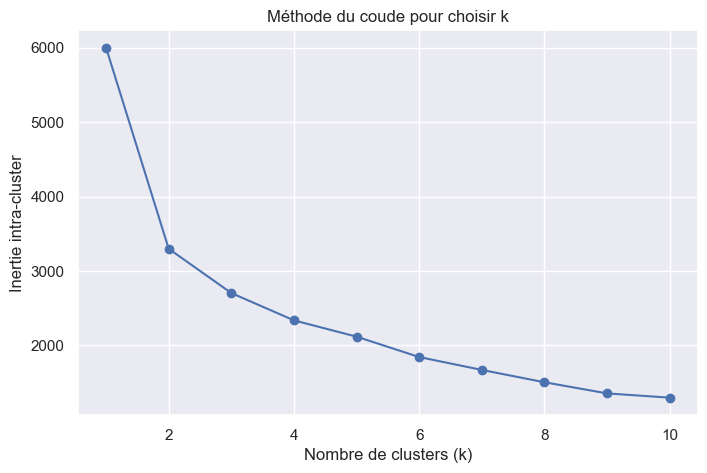

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 📐 Méthode du coude
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude pour choisir k")
plt.grid(True)
plt.show()


### 🔢 Application de K-Means avec le bon k
On applique K-Means avec le `k` choisi (ici k = 4).
On ajoute ensuite l’étiquette de cluster dans notre tableau `product_agg`.


In [27]:
# 🚀 K-Means avec k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 🏷️ Ajouter les clusters dans le DataFrame
product_agg["cluster"] = clusters


### Analyse des profils de clusters
On calcule la moyenne de chaque variable pour chaque cluster afin de mieux comprendre ce que représente chaque groupe :
- Quels sont les produits les plus chers ?
- Quels clusters ont beaucoup de retours ?
- Où sont les faibles volumes ?


In [28]:
# 🧮 Calcul des moyennes par cluster
cluster_summary = product_agg.groupby("cluster")[[
    "quantité_commandée", "quantité_expediée", "prix",
    "retour", "stock_minimum", "niveau_stock"
]].mean().round(2)

# 👁️ Affichage
cluster_summary


,quantité_commandée,quantité_expediée,prix,retour,stock_minimum,niveau_stock
cluster,,,,,,
0,51.44,50.88,302.55,0.25,27.58,141.38
1,52.54,51.84,127.64,0.23,63.07,178.89
2,809.07,798.81,258.24,13.78,50.66,139.78
3,50.55,50.03,367.73,0.18,74.59,122.10


### 🧠 Interprétation des clusters produits

À partir des moyennes observées dans chaque cluster, voici une interprétation détaillée du profil de chaque groupe de produits identifié par l’algorithme K-Means :

| Cluster | Prix moyen | Quantité commandée | Taux de retour | Stock réel | Profil interprété |
|---------|------------|---------------------|----------------|-------------|--------------------|
| **0**   | Moyen (~302) | Moyen (~51)         | Bas (~0.25)    | Moyen       | Produits **équilibrés** : ni trop chers, ni trop demandés, avec peu de retours. Bon compromis. |
| **1**   | Bas (~127)  | Faible (~52)        | Bas (~0.23)    | Élevé       | Produits **d’entrée de gamme ou promotionnels**, peu demandés mais stockés massivement. Faible marge probable. |
| **2**   | Moyen+ (~258) | **Très élevé** (~809) | **Très élevé** (~13.78) | Moyen     | Produits **très populaires** mais avec **beaucoup de retours**. Attention à la qualité ou à l’adéquation produit/client. |
| **3**   | Élevé (~368) | Faible (~50)        | Très bas (~0.18) | Faible     | Produits **haut de gamme ou de niche**, peu commandés mais très fiables (quasi aucun retour). |

### ✅ Conclusion :
- Le cluster **2** contient des produits à surveiller malgré leur succès.
- Le cluster **3** regroupe des produits premium, peu demandés mais très stables.
- Le cluster **1** semble peu rentable : peu de commandes, beaucoup de stock.
- Le cluster **0** pourrait être la zone de confort : stable, équilibré.

👉 Cette lecture permet de prendre des décisions **opérationnelles ou marketing** en fonction du comportement des produits.


### Visualisation des clusters avec PCA
On utilise l’Analyse en Composantes Principales (PCA) pour réduire les dimensions et projeter les produits dans un espace 2D.
Chaque point est un produit, coloré selon son cluster.
Cela permet de vérifier visuellement la séparation des groupes.


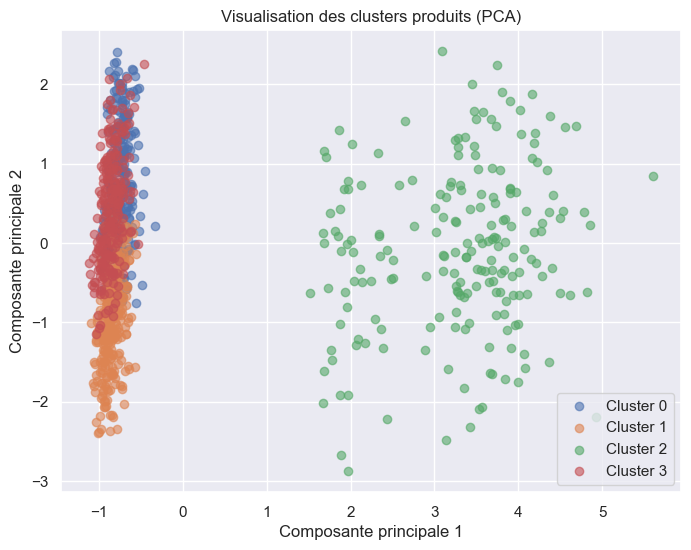

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 📉 Réduction à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 🔘 Intégration dans un DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = product_agg["cluster"]

# 🎨 Affichage du scatter plot
plt.figure(figsize=(8, 6))
for c in sorted(pca_df["cluster"].unique()):
    plt.scatter(pca_df[pca_df["cluster"] == c]["PC1"],
                pca_df[pca_df["cluster"] == c]["PC2"],
                label=f"Cluster {c}", alpha=0.6)

plt.title("Visualisation des clusters produits (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.show()


### 📉 Interprétation du graphique PCA

Ce graphique représente une **projection en 2D** des produits de la supply chain après application du **PCA (Analyse en Composantes Principales)**.

#### 🧠 Qu'est-ce qu'on voit ?
- **Chaque point** correspond à un produit.
- Les axes **PC1** et **PC2** sont des combinaisons optimales des variables d’origine (prix, quantité, retour, stock, etc.).
- La **position** d’un point reflète son **profil global** sur ces variables.
- Les **couleurs** indiquent les **clusters** attribués par K-Means.

#### 🔍 Comment interpréter le graphe ?
- Les produits **proches les uns des autres** partagent des caractéristiques similaires.
- Les produits **éloignés** ont des profils très différents.
- Si un cluster est bien **séparé spatialement**, cela signifie qu’il est **statistiquement distinct**.
- Un cluster **mélangé ou superposé** à un autre peut partager des caractéristiques avec lui.

#### 💡 Ce qu'on remarque ici :
- Le **Cluster 2 (vert)** est clairement séparé des autres → il représente probablement des produits très spécifiques ou extrêmes (ex. très commandés ou avec beaucoup de retours).
- Les **Clusters 0, 1 et 3** sont plus proches les uns des autres → leurs produits ont des comportements assez similaires.

#### 🎯 Objectif de cette visualisation
La PCA aide à **valider visuellement** la qualité du clustering et à identifier des groupes distincts ou des cas flous.

📌 *Attention : seule une partie de l'information est représentée ici (2 composantes sur 6 dimensions), donc cette vue simplifie la réalité.*


### Aperçu des produits dans chaque cluster
Ce bloc affiche pour chaque cluster :
- 3 produits (en tête de liste),
- avec leurs informations clés : catégorie, marque, prix, quantités, retours, stock…

Cela permet de comprendre concrètement le **type de produits regroupés dans chaque cluster**, en complément du tableau de moyennes.


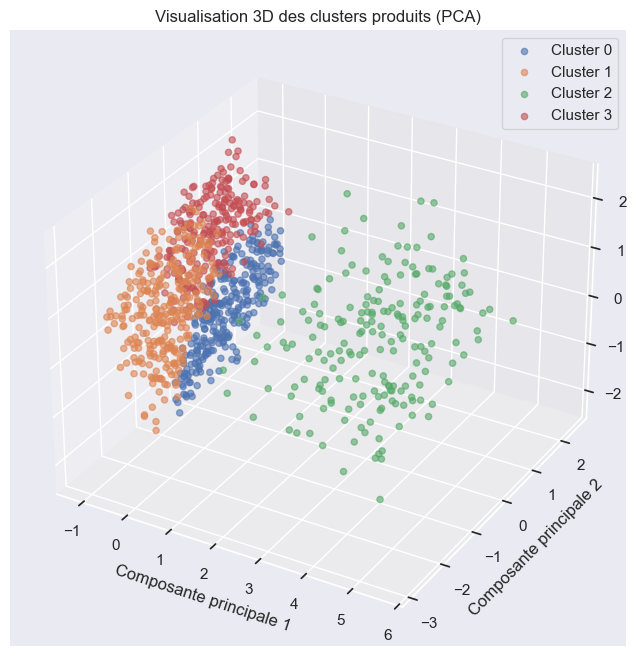

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
 
# 🔘 Intégration dans un DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2","PC3"])
pca_df["cluster"] = product_agg["cluster"]
 
# 📉 Réduction à 3 dimensions
# 🎨 Affichage du scatter plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
 
# 🟢 Tracer chaque cluster avec une couleur différente
for c in sorted(pca_df["cluster"].unique()):
    cluster_data = pca_df[pca_df["cluster"] == c]
    ax.scatter(cluster_data["PC1"], cluster_data["PC2"], cluster_data["PC3"],
               label=f"Cluster {c}", alpha=0.6)
 
# 🏷️ Titres et axes
ax.set_title("Visualisation 3D des clusters produits (PCA)")
ax.set_xlabel("Composante principale 1")
ax.set_ylabel("Composante principale 2")
ax.set_zlabel("Composante principale 3")
ax.legend()
plt.show()
 

## 📊 Visualisation 3D des clusters produits (PCA)
 
Ce graphique présente une **projection 3D** des produits à l’aide de l’**Analyse en Composantes Principales (PCA)**, après application d’un algorithme de **clustering (K-Means)**.
 
---
 
### 🔍 Comprendre ce que montre le graphique
 
- Chaque **point** représente un **produit** caractérisé par des variables comme le **prix**, **les quantités vendues**, **les retours**, **le stock**, etc.
- Les axes **Composante principale 1**, **2** et **3** sont des combinaisons linéaires optimales des variables d’origine, utilisées pour **réduire la dimension** tout en **préservant un maximum d'information**.
- Les **couleurs** représentent les **clusters** obtenus par l'algorithme de regroupement.
 
---
 
### 🧠 Interprétation des groupes visibles
 
- Le **Cluster 2 (vert)** est nettement **isolé**, ce qui indique des produits aux **caractéristiques très distinctes** (ex : très forte demande, marges élevées, ou retours anormaux).
- Les **Clusters 0 (bleu)**, **1 (orange)** et **3 (rouge)** sont **plus denses et proches**, ce qui montre des **profils similaires** entre les produits qu’ils contiennent.
- La **proximité** ou **superposition** partielle entre ces trois clusters peut indiquer :
  - une **frontière floue** entre certains groupes,
  - ou que des variables discriminantes ne sont pas totalement capturées dans les **3 premières composantes principales**.
 
---
 
### 🎯 Objectif de la visualisation
 
- **Valider visuellement** la qualité du clustering.
- **Identifier** les groupes bien séparés et ceux plus ambigus.
- Fournir une base pour **des décisions stratégiques** : optimisation du stock, segmentation marketing, gestion des retours, etc.
 
---
 
> 📝 **Remarque** : cette visualisation est une simplification, basée uniquement sur **3 dimensions** extraites des données. Il est possible que des variables importantes soient masquées dans des composantes non représentées ici.
 

In [30]:
# 🔁 Boucle sur chaque cluster pour afficher 3 exemples de produits
for c in sorted(product_agg["cluster"].unique()):
    print(f"\n🟢 Cluster {c} :")
    display(product_agg[product_agg["cluster"] == c][[
        "id_produit", "catégorie", "marque", "prix", "quantité_commandée", 
        "retour", "niveau_stock"
    ]].head(3))



🟢 Cluster 0 :


,id_produit,catégorie,marque,prix,quantité_commandée,retour,niveau_stock
3,P00004,Accessoires,Reflet d'or,462.80,90,1,57.0
4,P00005,Accessoires,Elixir Haute Beauté,359.47,31,0,65.0
6,P00007,Maquillage,Maison Pure,296.62,28,0,165.0



🟢 Cluster 1 :


,id_produit,catégorie,marque,prix,quantité_commandée,retour,niveau_stock
5,P00006,Parfums,Luxe eclat,93.22,57,0,182.0
12,P00013,Accessoires,Essentielle Paris,236.40,40,0,219.0
22,P00023,Soins capillaires,Essentielle Paris,46.29,74,1,298.0



🟢 Cluster 2 :


,id_produit,catégorie,marque,prix,quantité_commandée,retour,niveau_stock
1,P00002,Accessoires,Maison Pure,291.26,937,11,286.0
7,P00008,Maquillage,Essentielle Paris,311.22,740,17,296.0
8,P00009,Maquillage,Reflet d'or,223.58,907,18,88.0



🟢 Cluster 3 :


,id_produit,catégorie,marque,prix,quantité_commandée,retour,niveau_stock
0,P00001,Soins capillaires,Luxe eclat,467.42,62,1,88.0
2,P00003,Maquillage,Essentielle Paris,354.39,57,0,95.0
9,P00010,Accessoires,Elixir Haute Beauté,373.49,64,0,108.0
